# The realization of a dream: open a Sushi Bar in Bologna

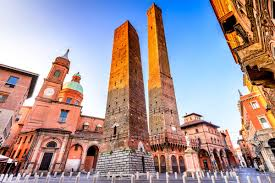

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction/Business Problem <a name="introduction"></a>

An old aunt left a nice nest egg to the undersigned: 3 million euros. I can finally realize my dream: to open a trendy restaurant in one of the most beautiful Italian cities.
I have always worked in the world of catering and I am doing well in the kitchen. To follow my dreams I went to Japan and spent 5 wonderful years learning the secrets of Sushi. Also I love being among young people. So my dream is to open a Sushi Bar in a university city where there are many young people. The choice falls on Bologna, a city full of young people with a historical university. The opening price may be lower than in other cities. There would be competition in any case because Bologna is full of clubs. There are not as many foreign tourists as in Rome or Milan, so opening in Bologna would have this penalty. But the city is sensitive to news and this is a plus.<br/>
Since I am convinced of my skills and the fact that my Sushi bar can offer something better than the competition, I will try to rent the place where there is a greater concentration of restaurants and possibly Sushi Bars.
Obviously I will try to stay as close as possible to the center, compatibly with the cost of the rent. <br/>
I will try to identify areas with the biggest concentation of young people. <br/>

This study will help anyone who wants to start a restaurant business in a young and dynamic city like Bologna
The business plan that will be illustrated has a general value: anyone who wants to open a restaurant somewhere will find the illustrated methodology and the examples provided useful. The considerations made can be applied to any city and to any type of restaurant / pub / caffee shop etc etc.

## Data <a name="data"></a>

The following data sources will be needed to extract/generate the required information:
* A Pandas dataframe will be provided with some data about the main Bologna's neighborhoods (name, density of inhabitants, distance from the University, cost of rent)
* The dataframe will be enriched by the centers of candidate areas that will be generated algorithmically and approximate addresses of centers of those areas will be obtained using Google Maps API reverse geocoding.
* Number of restaurants and their type and location in every neighborhood will be obtained using Foursquare API. Through a Bubble Chart it will be possible to identify the areas with the highest concentration of restaurants.
* The list of Sushi Bars in the Bologna neighbourhoods and their location with respect to the city center will retrieved using Foursquare API.
* For each Sushi Bar I will analyze the number of clicks received and the comments. From these data I will be able to understand the age of the clientele in relation the position of the restaurant itself.

The area where the Sushi Bar will be opened will be chosen according to the following criteria:
    - density of restaurants
    - density of competitor Sushi bars
    - distance from the University
    - density of young population
